<a href="https://colab.research.google.com/github/rishav1122/Audio-controlled-drone/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# loading all the required packages

import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout
from keras.layers import LSTM, GRU
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import os, sys
import matplotlib.pyplot as plt
import librosa
from librosa import display
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# importing the google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('gdrive/My Drive/Audio_Controlled_Drone/Dataset')

In [ ]:
hover = []
land = []
mback = []
mfor = []
mleft = []
mright = []
takeoff = []

hover = os.listdir('hover')
land = os.listdir('land')
mback = os.listdir('mback')
mfor = os.listdir('mfor')
mleft = os.listdir('mleft')
mright = os.listdir('mright')
takeoff = os.listdir('takeoff')

names_list  = ['hover', 'land', 'mback', 'mfor', 'takeoff', 'mleft', 'mright']
list = [hover, land, mback, mfor, takeoff, mleft, mright]

In [ ]:
!dir

hover  land  mback  mfor  mleft  model_1.h5  model.h5  mright  takeoff


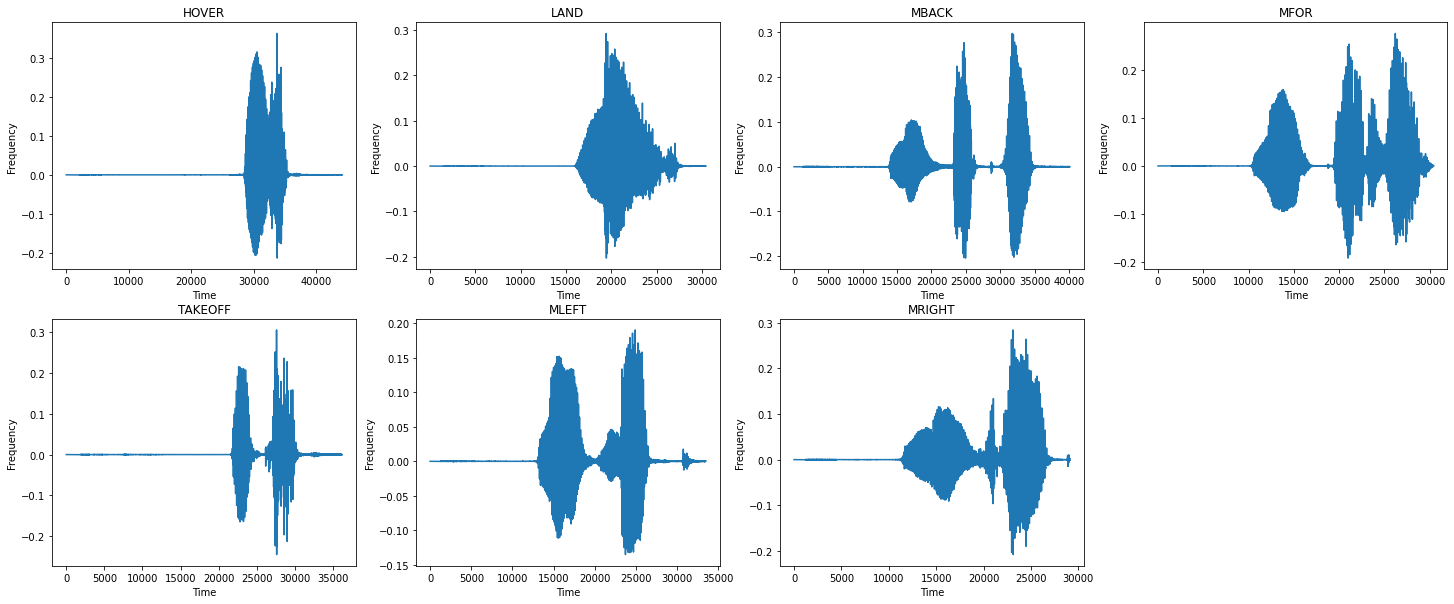

In [ ]:
fig = plt.figure(figsize=(25, 10))
rows = 2
columns = 4
r=0
for i in list:
    fig.add_subplot(rows, columns, r+1)
    audio, sample_rate = librosa.load(names_list[r]+'/'+names_list[r]+'75.wav', duration=3) 
    plt.plot(audio)
    plt.axis('on')
    plt.title(names_list[r].upper())
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    r+=1

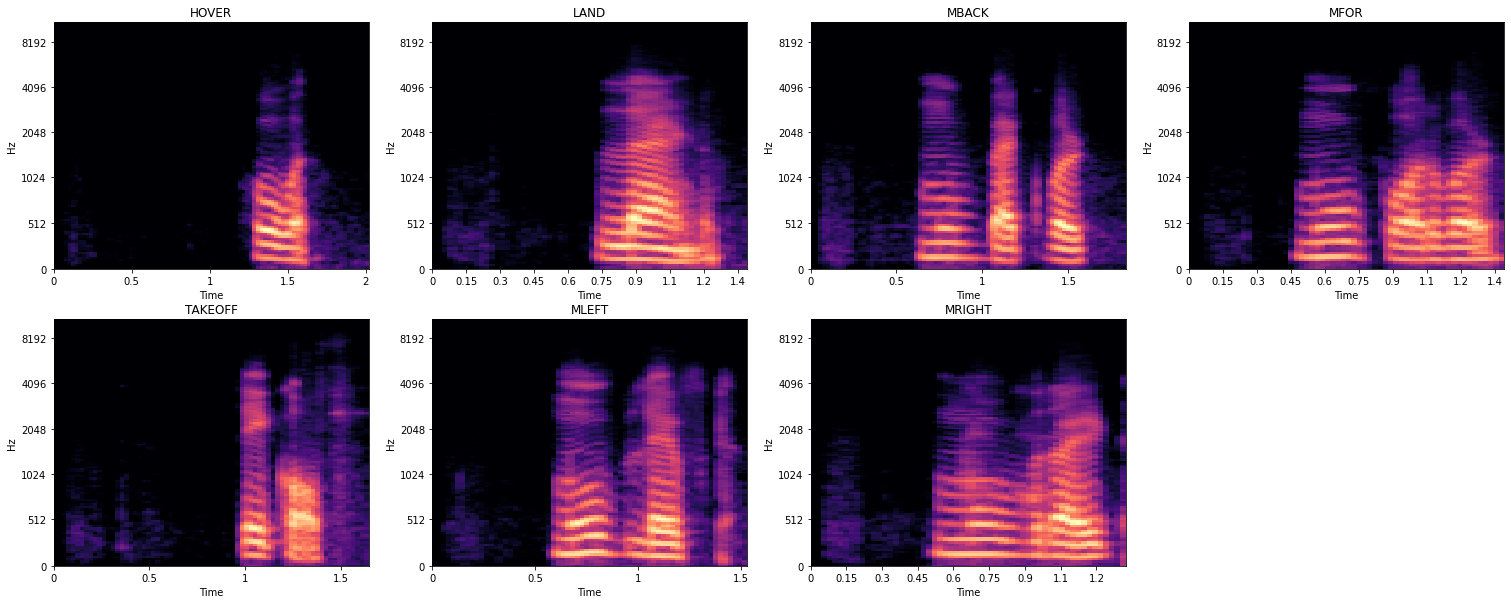

In [ ]:
fig = plt.figure(figsize=(26, 10))
rows = 2
columns = 4
r=0
for i in list:
    fig.add_subplot(rows, columns, r+1)
    audio, sample_rate = librosa.load(names_list[r]+'/'+names_list[r]+'75.wav', duration=3) 
    mels = librosa.feature.melspectrogram(y=audio,sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(mels,ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title(names_list[r].upper())
    r+=1

In [ ]:
# res_type is resample type i.e. kaiser_type in this case
# librosa.feature.mfcc returns MFCC sequence of shape (n_mfcc, t)
# n_mfcc: no. of MFCCs returned, can be changes by giving argument, n_mfcc = 20 is by default

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate) #can change number of features
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [ ]:
#def features_extractor_new(file_name):
#  audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
#  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate) #can change number of features
#  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#  return mfccs_scaled_features

r = 0
j = 'hover37.wav'

#data_new = features_extractor_new(names_list[r]+'/'+j)
#print(data_new)
#data_new.shape


audio, sample_rate = librosa.load(names_list[r]+'/'+j, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate) #can change number of features
mfccs_features.shape
#mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#mfccs_scaled_features.shape

(20, 55)

In [ ]:
extracted_features = []
r=0
for i in list:
    for j in i:
        data=features_extractor(names_list[r]+'/'+j)
        extracted_features.append([data,r])
    r+=1

In [ ]:
len(extracted_features)

700

In [ ]:
extracted_features[321]

[array([-348.93442   ,  124.336105  ,   31.04157   ,   24.889841  ,
         -10.536381  ,   -8.7722    ,  -16.23414   ,    2.8428848 ,
         -26.860668  ,    2.6354077 ,  -10.916017  ,  -11.223864  ,
          -3.7480102 ,  -16.163315  ,   -2.005101  ,   -3.8363628 ,
          -7.5309777 ,   -7.5317616 ,   -0.49401024,    0.40487853],
       dtype=float32), 3]

In [ ]:
df=pd.DataFrame(extracted_features,columns=['feature','class'])

In [ ]:
df.shape

(700, 2)

In [ ]:
df.head(10)

,feature,class
0,"[-390.97107, 121.30149, -25.223562, 7.9647846,...",0
1,"[-601.4917, 28.277977, -0.11554617, 0.46289173...",0
2,"[-339.73822, 133.65117, -20.911839, 11.907706,...",0
3,"[-440.81723, 130.79251, -20.845499, 4.00189, -...",0
4,"[-301.46558, 133.55794, 9.93764, 12.280746, -7...",0
5,"[-340.22604, 152.25826, -65.76654, 4.907359, -...",0
6,"[-528.10724, 76.55931, 6.4072266, 5.9208035, -...",0
7,"[-300.78854, 146.3909, -39.75446, 1.0407895, -...",0
8,"[-518.6715, 84.99098, 10.833826, -12.000635, -...",0
9,"[-324.28156, 121.686195, 0.33114696, 3.2572942...",0


In [ ]:
df['feature'][0]

array([-390.97107  ,  121.30149  ,  -25.223562 ,    7.9647846,
        -18.133902 ,   -8.273921 ,    5.5676537,   -3.1741874,
        -15.626855 ,   -7.440823 ,   -6.77031  ,   -2.4559464,
         -3.9868789,   -4.006516 ,   -3.341438 ,   -2.7969456,
         -2.8854566,   -5.541496 ,   -1.9537412,   -9.526413 ],
      dtype=float32)

In [ ]:
df['feature']

0      [-390.97107, 121.30149, -25.223562, 7.9647846,...
1      [-601.4917, 28.277977, -0.11554617, 0.46289173...
2      [-339.73822, 133.65117, -20.911839, 11.907706,...
3      [-440.81723, 130.79251, -20.845499, 4.00189, -...
4      [-301.46558, 133.55794, 9.93764, 12.280746, -7...
                             ...                        
695    [-357.49786, 103.36262, -6.8585596, 15.650825,...
696    [-486.96982, 109.66109, 16.955786, 14.556486, ...
697    [-528.27606, 107.66405, -31.501175, 11.8297825...
698    [-620.1334, 88.63358, 27.416939, 17.818329, -2...
699    [-444.39062, 93.31127, -13.664072, 31.284811, ...
Name: feature, Length: 700, dtype: object

In [ ]:
df['feature'].tolist()

[array([-390.97107  ,  121.30149  ,  -25.223562 ,    7.9647846,
         -18.133902 ,   -8.273921 ,    5.5676537,   -3.1741874,
         -15.626855 ,   -7.440823 ,   -6.77031  ,   -2.4559464,
          -3.9868789,   -4.006516 ,   -3.341438 ,   -2.7969456,
          -2.8854566,   -5.541496 ,   -1.9537412,   -9.526413 ],
       dtype=float32),
 array([-6.0149170e+02,  2.8277977e+01, -1.1554617e-01,  4.6289173e-01,
        -1.9774648e+00, -4.6894870e+00, -3.1607087e+00,  2.1340065e+00,
        -3.0201306e+00, -1.7858125e+00,  2.3401733e-02, -1.2328541e-02,
        -6.5882826e-01, -3.3176336e-01,  1.1464040e+00,  1.2421650e+00,
        -1.9870415e+00, -9.4161314e-01, -2.9885641e-01, -3.2232313e+00],
       dtype=float32),
 array([-339.73822   ,  133.65117   ,  -20.911839  ,   11.907706  ,
         -14.694776  ,    5.4439445 ,    6.252281  ,    6.257737  ,
         -17.81159   ,   -3.628164  ,   -4.3172374 ,   -6.0531344 ,
           2.788569  ,   -0.8202829 ,   -3.3288376 ,    0.60065395,


In [ ]:
X = np.array(df['feature'].tolist())
y = np.array(df['class'].tolist())

# Label-Encoder: Encode target labels with value between 0 and n_classes-1.
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=1)

In [ ]:
X.shape

(700, 20)

In [ ]:
y.shape

(700, 7)

In [ ]:
print(X_train.shape, " ", X_test.shape, " ")

(560, 20)   (140, 20)  


In [ ]:
X_train.shape

(560, 20)

In [ ]:
X_train[0].shape

(20,)

In [ ]:
y_train.shape

(560, 7)

In [ ]:
y_train = np.reshape(y_train, (560,1,7))

In [ ]:
y_test = np.reshape(y_test, (140,1,7))

In [ ]:
X_train = np.reshape(X_train, (560,1,20))

In [ ]:
X_test = np.reshape(X_test, (140,1,20))

In [ ]:
from keras.layers import Input, Conv1D, TimeDistributed, Bidirectional, CuDNNLSTM, Attention
from keras.models import Model

In [ ]:
# X_input = Input(shape = input_shape)

input_shape = (1, 20)
X_input = Input(shape = input_shape)


X_1 = LSTM(units = 128, return_sequences = True)(X_input)
X_1 = Dropout(rate = 0.2)(X_1)
X_1 = BatchNormalization()(X_1)

X_1 = LSTM(units = 128, return_sequences = True)(X_input)
X_1 = Dropout(rate = 0.2)(X_1)
X_1 = BatchNormalization()(X_1)

X_1 = LSTM(units = 64, return_sequences = True)(X_input)
X_1 = Dropout(rate = 0.2)(X_1)
X_1 = BatchNormalization()(X_1)

X_1 = TimeDistributed(Dense(7, activation = "sigmoid"))(X_1)

model = Model(inputs = X_input, outputs = X_1)


In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1, 20)]           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 1, 64)             21760     
_________________________________________________________________
dropout_56 (Dropout)         (None, 1, 64)             0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 1, 64)             256       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 1, 7)              455       
Total params: 22,471
Trainable params: 22,343
Non-trainable params: 128
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model_save_filename = "model_1.h5"

In [ ]:
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy",mode='max', save_best_only=True)
history = model.fit(X_train, y_train, batch_size = 50, epochs=1000, validation_data=(X_test, y_test),callbacks=[mdlcheckpoint_cb],verbose=1)

Epoch 1/1000
12/12 [==============================] - 3s 71ms/step - loss: 2.0643 - accuracy: 0.1293 - val_loss: 1.9851 - val_accuracy: 0.0929
Epoch 2/1000
12/12 [==============================] - 0s 8ms/step - loss: 1.9867 - accuracy: 0.1996 - val_loss: 1.9784 - val_accuracy: 0.1071
Epoch 3/1000
12/12 [==============================] - 0s 10ms/step - loss: 1.9529 - accuracy: 0.2114 - val_loss: 1.9670 - val_accuracy: 0.1071
Epoch 4/1000
12/12 [==============================] - 0s 9ms/step - loss: 1.9558 - accuracy: 0.1667 - val_loss: 1.9658 - val_accuracy: 0.1214
Epoch 5/1000
12/12 [==============================] - 0s 8ms/step - loss: 1.9709 - accuracy: 0.1651 - val_loss: 1.9671 - val_accuracy: 0.1357
Epoch 6/1000
12/12 [==============================] - 0s 9ms/step - loss: 1.9678 - accuracy: 0.1386 - val_loss: 1.9506 - val_accuracy: 0.1286
Epoch 7/1000
12/12 [==============================] - 0s 8ms/step - loss: 1.9302 - accuracy: 0.1983 - val_loss: 1.9488 - val_accuracy: 0.0929
Epoc

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [ ]:
#model = keras.models.load_model('model.h5')
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.26428571343421936
